In [1]:
metric_path = '../Metrics/Results/cartolastd.csv'

In [2]:
# %matplotlib notebook
# %matplotlib notebook
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
# plt.style.use('seaborn-white')

In [3]:
matches = re.match(r".*/(.*).csv", metric_path)
dataset_id = matches.group(1)

metric_df = pd.read_csv(metric_path, index_col=0)
metric_df.index = metric_df.index.str.extract(r'.*/{}-(.*).csv'.format(dataset_id), expand=False) # Clean string

In [4]:
dataset_id

'cartolastd'

In [5]:
df = metric_df[[col for col in metric_df.columns if 'spat_np_' in col]]
df.columns = df.columns.str.strip('spat_np_')
df.index = reversed(df.index)
n_timesteps = len(df.columns)

In [6]:
colors = []
for index in df.index.str.split('_').str[0]:
    if 'AE' in index:
        colors.append([1,0,0,1])
    if 'tsne' in index:
        colors.append([.2,.7,.3,1])
    if 'pca' in index:
        colors.append([0,0,1,1])

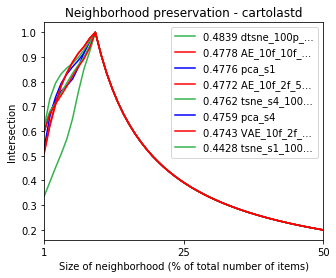

In [7]:
fig, ax = plt.subplots(figsize=(5,4))
for line, index, color in zip(df.values, df.index, colors):
    avg = np.mean(line)
    label = '{:.4f} {}'.format(avg, index)
    if len(label) > 18:
        label = label[:18] + '...'
    l = ax.plot(line, c=color, label=label)

ax.set_ylabel('Intersection')
ax.set_xlabel('Size of neighborhood (% of total number of items)')

ax.set_xlim(0, n_timesteps-1)
plt.xticks([0, (n_timesteps-1)/2, n_timesteps-1], ('1', str(int((n_timesteps)/2)), str(n_timesteps)))
ax.legend()
plt.title('Neighborhood preservation - {}'.format(dataset_id))

# Re-sort legend
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: -float(t[0].split(' ')[0])))
ax.legend(handles, labels)

fig.savefig('Raw/{}-np.eps'.format(dataset_id), format='eps')

In [8]:
df = metric_df[[col for col in metric_df.columns if 'spat_nh_' in col][:10]]
n_timesteps = len(df.columns)

In [9]:
colors = []
for index in df.index.str.split('_').str[0]:
    if 'AE' in index:
        colors.append([1,0,0,1])
    if 'tsne' in index:
        colors.append([.2,.7,.3,1])
    if 'pca' in index:
        colors.append([0,0,1,1])

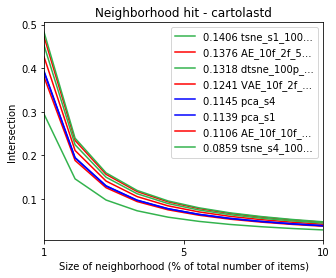

In [10]:
fig, ax = plt.subplots(figsize=(5,4))
for line, index, color in zip(df.values, df.index, colors):
    avg = np.mean(line)
    label = '{:.4f} {}'.format(avg, index)
    if len(label) > 18:
        label = label[:18] + '...'
    l = ax.plot(line, c=color, label=label)

ax.set_ylabel('Intersection')
ax.set_xlabel('Size of neighborhood (% of total number of items)')

ax.set_xlim(0, n_timesteps-1)
plt.xticks([0, (n_timesteps-1)/2, n_timesteps-1], ('1', str(int((n_timesteps)/2)), str(n_timesteps)))
ax.legend()
plt.title('Neighborhood hit - {}'.format(dataset_id))

# Re-sort legend
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: -float(t[0].split(' ')[0])))
ax.legend(handles, labels)

fig.savefig('Raw/{}-nh.eps'.format(dataset_id), format='eps')

In [11]:
# KL metrics have numerical problems
metric_df = metric_df.drop(['spat_kl', 'stab_kl'], axis=1)

In [12]:
def plot_matrix(df, shared_cm=True, cell_text=False, invert_colormap=[], title=None, show=True):
    fig = plt.figure(figsize=(5.5,5.5))
    ax = fig.add_subplot(111)
    
    matrix = df.values
    metric_ids = df.columns
    dataset_ids = df.index

    if shared_cm:
        # All column share same colormap range
        mat = ax.matshow(matrix, cmap=plt.cm.gist_yarg)
        if cell_text is False:
            fig.colorbar(mat, orientation="horizontal", pad=0.1)

    else:
        # The colormap range is independent for each column
        for i, metric in enumerate(metric_ids):
            # Make all rows invalid (fill with 1) except the target one (col)
            m = np.ones_like(matrix)
            m[:, i] = 0
            masked = np.ma.masked_array(matrix, m)
            if metric in invert_colormap:
                colormap = plt.cm.YlGn
            else:
                colormap = plt.cm.YlGn_r
            ax.matshow(masked, cmap=colormap)

    # Ticks, labels and grids
    ax.set_xticklabels(metric_ids, rotation='vertical')
    ax.set_xticks(range(len(metric_ids)), minor=False)
    ax.set_yticklabels(dataset_ids)
    ax.set_yticks(range(len(dataset_ids)), minor=False)
    ax.set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor=True)
    ax.set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor=True)
    ax.grid(which='minor', color='#FFFFFF', linestyle='-', linewidth=2)
    ax.tick_params(axis=u'both', which=u'both', length=0)

    x_start = 0.0
    x_end = len(metric_ids)
    y_start = 0.0
    y_end = len(dataset_ids)

    # Add the text
    fontsize = 9
    if cell_text:
        jump_x = (x_end - x_start) / (2.0 * len(metric_ids))
        jump_y = (y_end - y_start) / (2.0 * len(dataset_ids))
        x_positions = np.linspace(start=x_start - 0.5, stop=x_end - 0.5, num=len(metric_ids), endpoint=False)
        y_positions = np.linspace(start=y_start - 0.5, stop=y_end - 0.5, num=len(dataset_ids), endpoint=False)

        for y_index, y in enumerate(y_positions):
            for x_index, x in enumerate(x_positions):
                label = "{0:.5f}".format(matrix[y_index][x_index])[:6]#.lstrip('0')
                text_x = x + jump_x
                text_y = y + jump_y
                color = 0
                if metric_ids[x_index] in invert_colormap:
                    color = not color
                    
                if matrix[y_index][x_index] < matrix[:, x_index].min() + (matrix[:, x_index].max() - matrix[:, x_index].min()) * .5:
                    color = not color
                color = 'white' if color else 'black' 
                ax.text(text_x, text_y, label, color=color, ha='center', va='center', fontsize=fontsize)


    if title is not None:
        ax.set_ylabel(title, labelpad=10, fontweight='bold')


#         csv_name = Globals.plot_subdir + title.replace(' ', '').lower() + '.csv'
#         save_as_cvs(matrix, dataset_ids, technique_ids, csv_name)

#         fig_name = title.replace(' ', '').lower()
#         fig_name += '-S' if shared_cm else '-I'
#         fig_name += '-T' if cell_text else '-NT'
#         fig_name += '.png'
# #         fig.savefig(Globals.plot_subdir + fig_name, dpi=500)

    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    fig.tight_layout()

    if show:
        plt.show()
    return fig

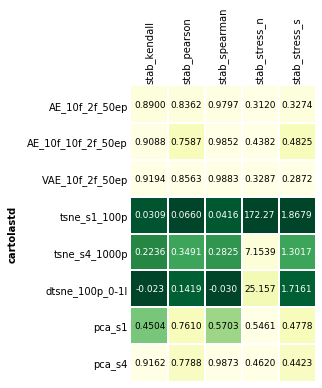

In [13]:
stab_metrics = metric_df[['stab_kendall', 'stab_pearson', 'stab_spearman', 'stab_stress_n', 'stab_stress_s']]
fig = plot_matrix(stab_metrics, cell_text=True, shared_cm=False,
                  title=dataset_id, invert_colormap=['stab_stress_n', 'stab_stress_s'])
fig.savefig('Raw/{}-stabmatrix.eps'.format(dataset_id), format='eps')

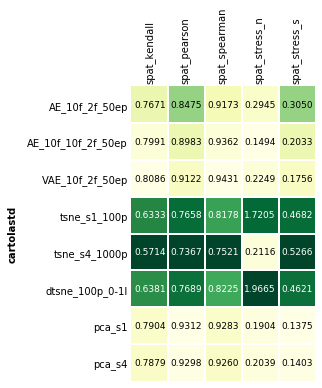

In [14]:
spat_metrics = metric_df[['spat_kendall', 'spat_pearson', 'spat_spearman', 'spat_stress_n', 'spat_stress_s']]
fig = plot_matrix(spat_metrics, cell_text=True, shared_cm=False, 
                  title=dataset_id, invert_colormap=['spat_stress_n', 'spat_stress_s'])

fig.savefig('Raw/{}-spatmatrix.eps'.format(dataset_id), format='eps')